In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Image_Captioning/

/content/drive/MyDrive/Image_Captioning


In [ ]:
! pip install keras-self-attention==0.50.0

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19397 sha256=d6c49c9acf5f58c0d83ebe83cdcaa24198ff83c1a9af7ba4b1acdc43b5f7f881
  Stored in directory: /root/.cache/pip/wheels/38/34/7c/c1269b8ceb122367bb8fd7b7f7dd950df941748823122b5284
Successfully built keras-self-attention


In [ ]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
from PIL import Image
import random
from pickle import dump, load
import keras
from wordcloud import WordCloud
from tqdm.notebook import tqdm
import seaborn as sns
import glob
import string
import cv2
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Bidirectional, Concatenate
from keras.optimizers import Adam, RMSprop
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Input
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention

## Read data

In [ ]:
image_path = 'flickr8k/Flicker8k_Dataset/'
dir_Flickr_text = 'flickr8k/Flickr8k.token.txt'
images_lst = glob.glob(image_path + '*.jpg')
no_of_image = len(images_lst)
print(f'Total Images in Datset : {no_of_image}')

Total Images in Datset : 8091


In [ ]:
def load_txt(txt_file):
  with open(txt_file,'r') as file:
    text = file.read()
  return text

def prepare_clean_txt(text):
  text_data = []
  table = str.maketrans('', '', string.punctuation)
  for line in tqdm(text.split('\n')):                          # spiltting over each line
    col = line.split('\t')                                     # splitting over each space in each line
    if len(col) == 1:                                          # neglecting data if full information not present
        continue
    filename, index = col[0].split("#")
    filename_path = image_path + filename                      # splitting to gather information about image index number and imageid
    txt = col[1].split()
    txt = [word.lower() for word in txt]                       # convert each word to lower case
    txt = [w.translate(table) for w in txt]                    # to remove punctuations from sentence
    txt = [word for word in txt if len(word)>1]                # to discard words of length 1
    txt = [word for word in txt if word.isalpha()]             # to discard numeric string
    txt = ' '.join(txt)
    text_data.append([index]+ [filename_path] + [txt])
  return text_data                                              # [index, filename, caption text]


def prepare_dataframes(text_data):
  data_df = pd.DataFrame(text_data, columns=[ 'index', 'filename', 'caption'])
  data_df = data_df[data_df.filename != 'flickr8k/Flicker8k_Dataset/2258277193_586949ec62.jpg.1']                          # removing data with improper imageid
  data_df['caption_with_tags'] = data_df['caption'].apply(lambda txt : 'startseq ' + txt + ' endseq')
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data_df.caption.values)
  data_df['caption_word_count'] = data_df['caption'].apply(lambda caption: len(caption.split()))
  word = []
  frequency = []
  for k,v in tokenizer.word_counts.items():
    word.append(k)
    frequency.append(v)
  df_word_count = pd.DataFrame({'word': word, 'frequency': frequency})
  df_word_count.sort_values('frequency', ascending=False, inplace=True, ignore_index=True)
  return data_df, df_word_count

In [ ]:
text = load_txt(dir_Flickr_text)
text_data = prepare_clean_txt(text)
caption_df, df_word_count = prepare_dataframes(text_data)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [ ]:
caption_df.head()

,index,filename,caption,caption_with_tags,caption_word_count
0,0,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,child in pink dress is climbing up set of stai...,startseq child in pink dress is climbing up se...,14
1,1,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,girl going into wooden building,startseq girl going into wooden building endseq,5
2,2,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,little girl climbing into wooden playhouse,startseq little girl climbing into wooden play...,6
3,3,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,little girl climbing the stairs to her playhouse,startseq little girl climbing the stairs to he...,8
4,4,flickr8k/Flicker8k_Dataset/1000268201_693b08cb...,little girl in pink dress going into wooden cabin,startseq little girl in pink dress going into ...,9


In [ ]:
from collections import Counter
def utility_counter(caption_df):
  filename = caption_df.filename.values
  caption_count = Counter(filename).values()
  uni_filenames = np.unique(filename)
  print(f'Number of unique file names : {len(uni_filenames)}')
  print(f'Number of captions per image : {set(caption_count)}')
  print(f'All image have same number of captions: {all(caption_count)}')

utility_counter(caption_df)

Number of unique file names : 8091
Number of captions per image : {5}
All image have same number of captions: True


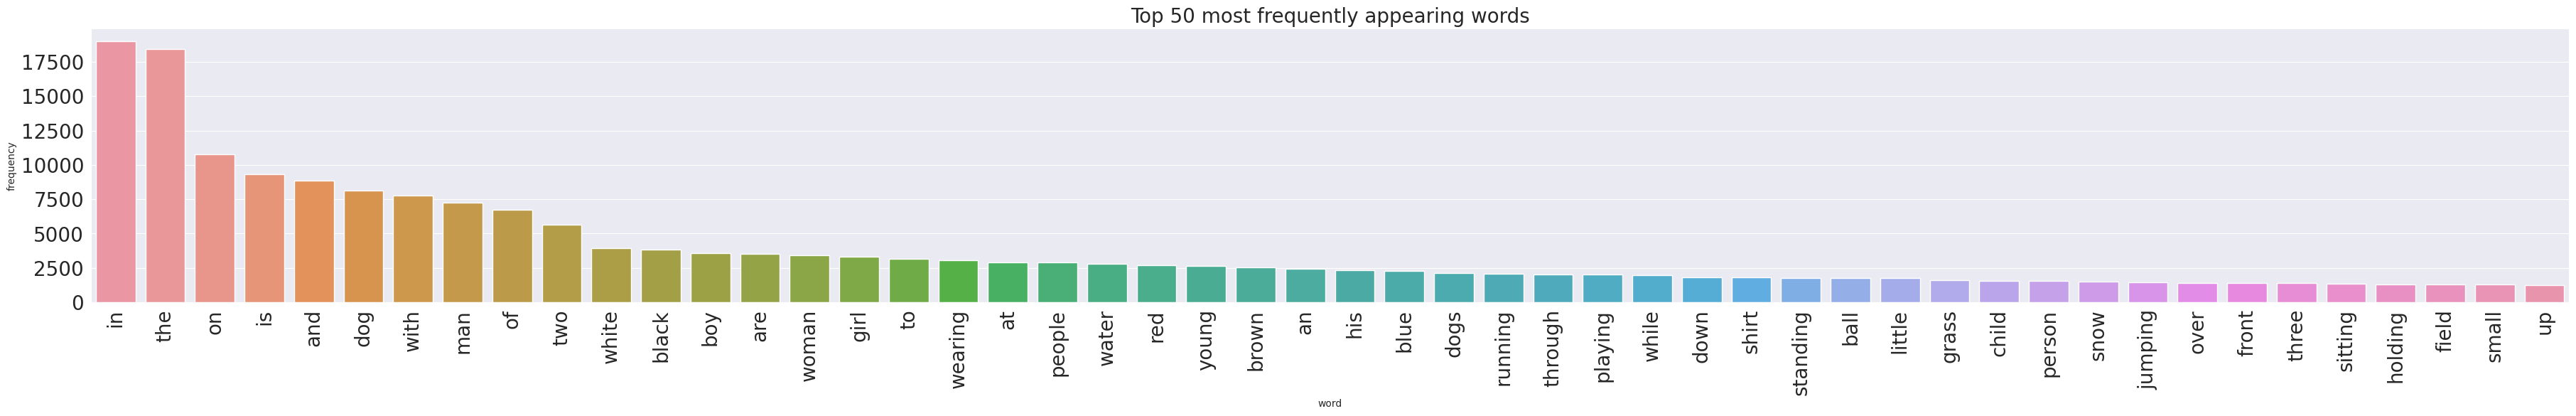

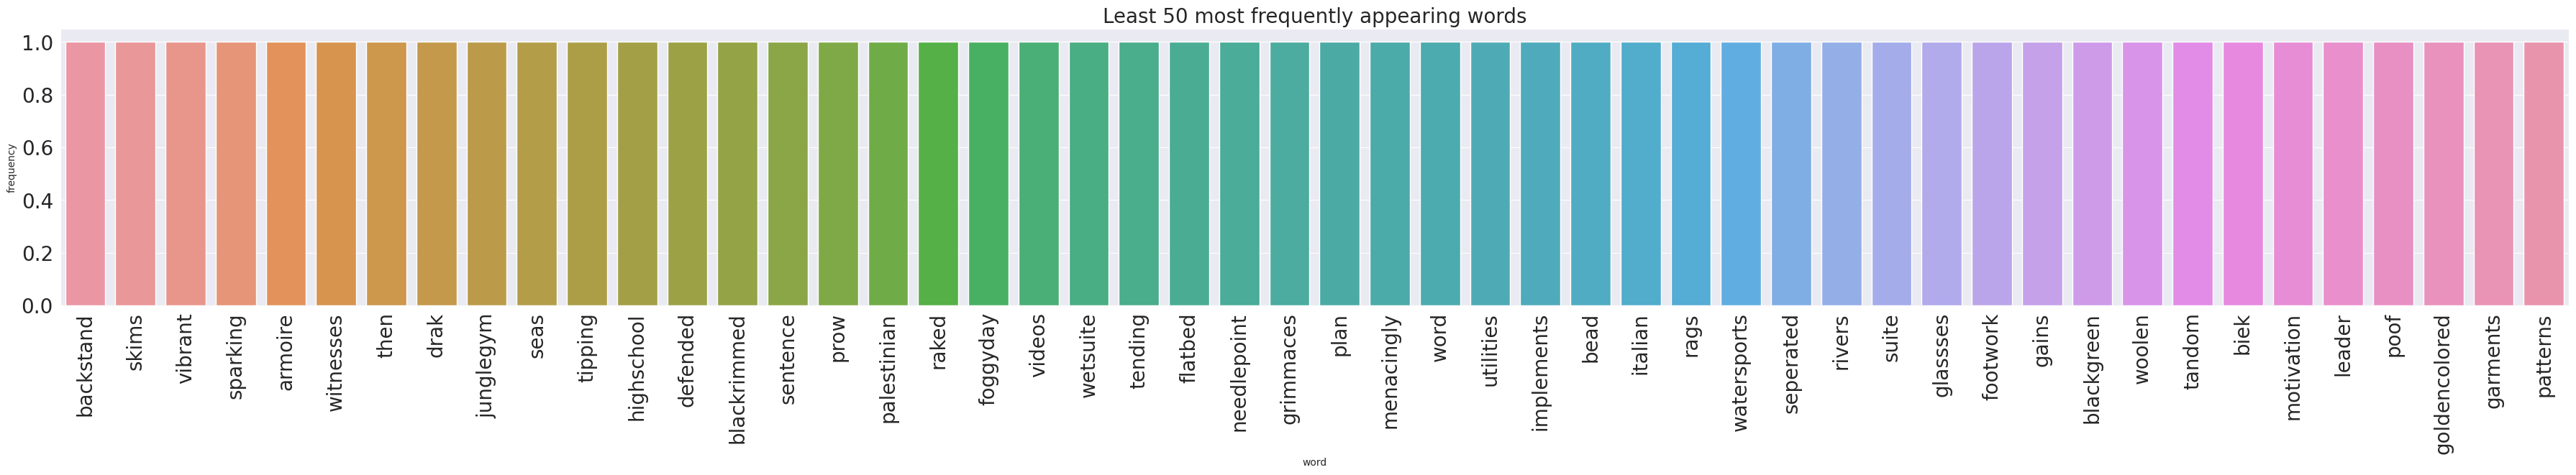

In [ ]:
count = 50

def plot_word_count(df, title = ''):
    sns.set_style('darkgrid')
    plt.figure(figsize = (45, 5))
    sns.barplot(x=df['word'], y=df["frequency"])
    plt.yticks(fontsize = 20)
    plt.xticks( rotation = 'vertical', fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.show()

plot_word_count(df_word_count.iloc[:count, :], title= 'Top 50 most frequently appearing words')
plot_word_count(df_word_count.iloc[-count:, :], title= 'Least 50 most frequently appearing words')

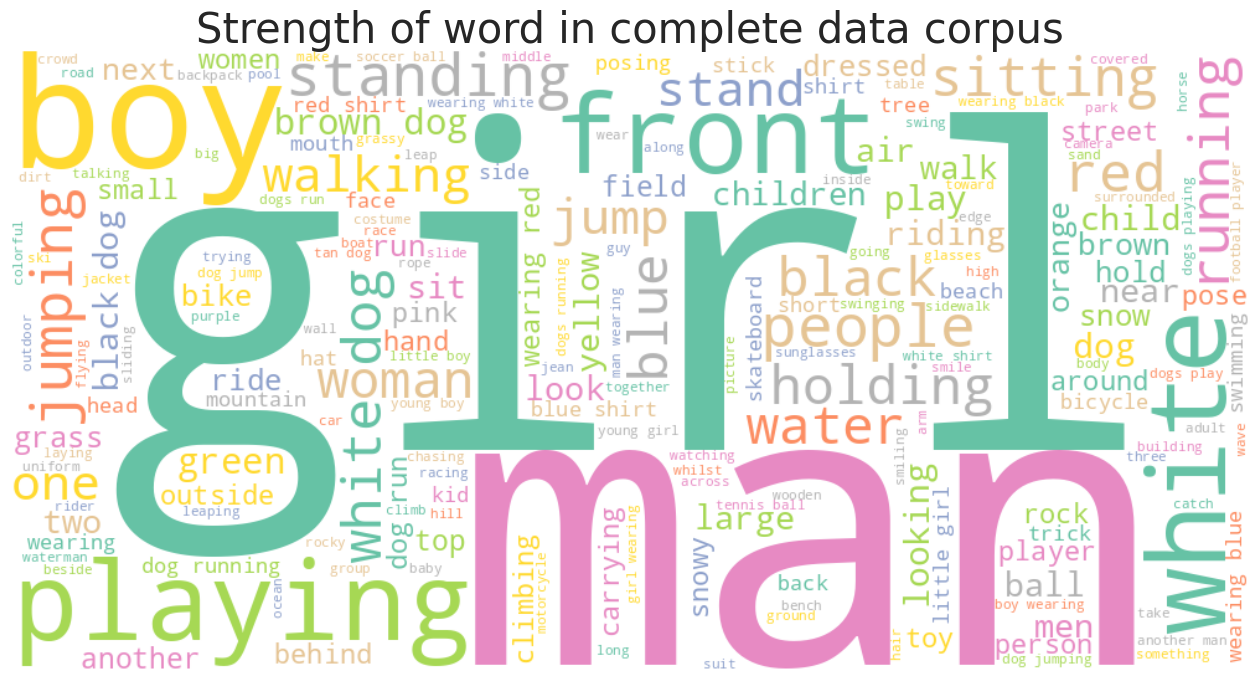

In [ ]:
text = ' '
for caption in caption_df.caption:
  text = text + caption
plt.figure(figsize=(16, 12))
word_cloud = WordCloud(width = 1000, height = 500, random_state=1, collocations= True, background_color = 'white', colormap='Set2').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Strength of word in complete data corpus', fontsize = 30)
plt.show()

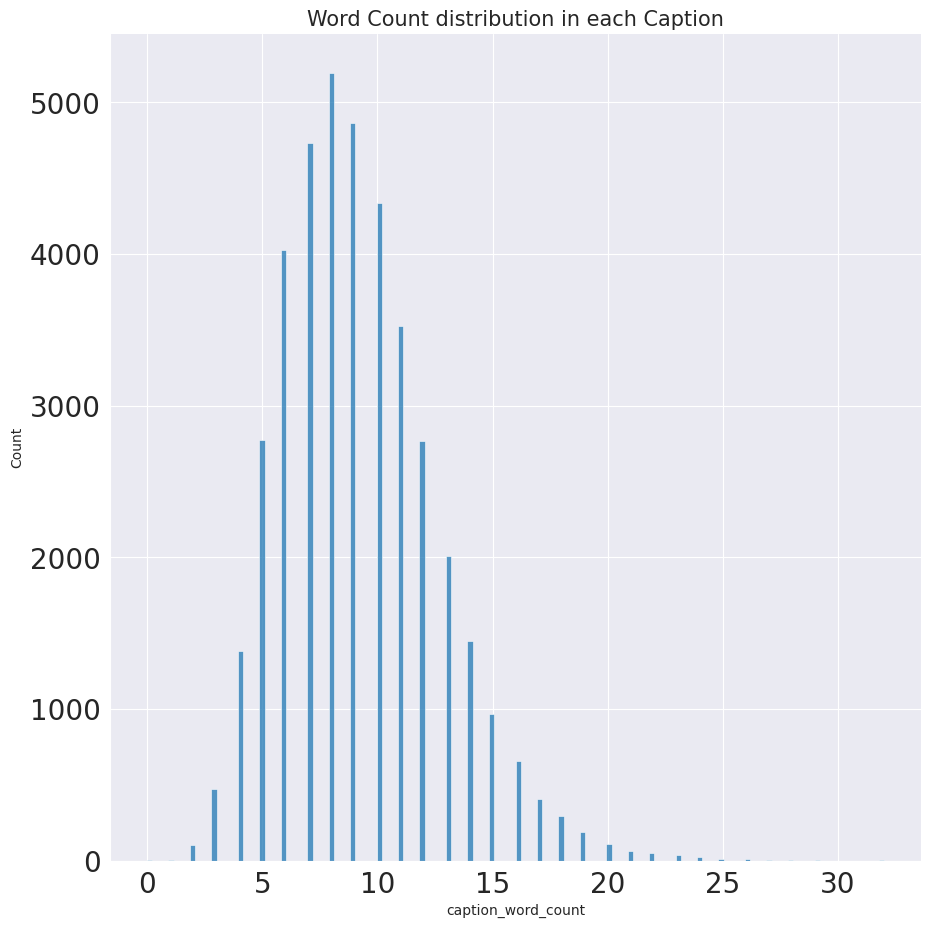

In [ ]:
sns.set_style('darkgrid')
sns.FacetGrid(caption_df, height = 9).map(sns.histplot, 'caption_word_count').add_legend()
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title('Word Count distribution in each Caption', fontsize = 15)
plt.show()

In [ ]:
caption_df = pd.read_csv("flickr8k/captions.txt")

In [ ]:
image_path = "flickr8k/Flicker8k_Dataset/"

105     A man uses ice picks and crampons to scale ice .
106    an ice climber in a blue jacket and black pant...
107          An ice climber scaling a frozen waterfall .
108    A person in blue and red ice climbing with two...
109                         Climber climbing an ice wall
Name: caption, dtype: object


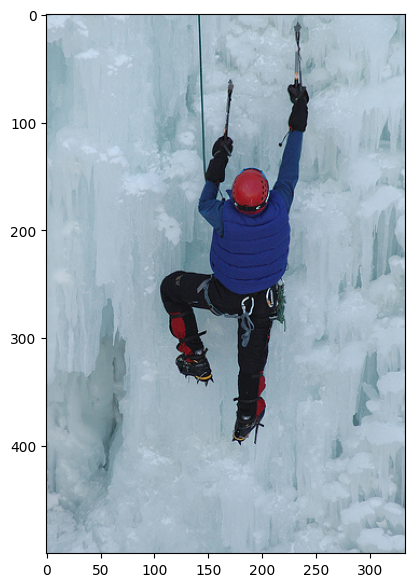

In [ ]:
n = 21
img = Image.open(image_path + caption_df['image'][5*n])
plt.figure(figsize=(7, 7))
plt.imshow(img)
print(caption_df['caption'][5*n:5*n+5])

In [ ]:
img.size # Need to resize

(333, 500)

## Word Embedding using glove6b

In [ ]:
caption_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
import re
def caption_preprocessing(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  # tokenize
  text=text.split()
  # convert to lower case
  text = [word.lower() for word in text]
  # remove hanging 's' and 'a'
  # text = [word for word in text if len(word)>1]

  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # store as string
  text =  ' '.join(text)

  # insert 'startseq', 'endseq' cho chuỗi
  text = 'startseq ' + text + ' endseq'
  return text

caption_df['caption'] = caption_df['caption'].apply(caption_preprocessing)

caption_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building e...
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...


In [ ]:
caption_df.shape

(40455, 2)

In [ ]:
word_counts = {}
max_length = 0
for text in caption_df['caption']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

8777
37


In [ ]:
# Chỉ lấy các từ xuất hiện trên 7 lần
word_count_threshold = 7
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 8777 -> 2424


In [ ]:
i2w = {}
w2i = {}

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(len(i2w), len(w2i))
print(i2w[300])

2424 2424
glass


In [ ]:
glove_dir = 'glove/'
embeddings_index = {} # empty dictionary
file = open(glove_dir + 'glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['girl'].shape

(200,)

In [ ]:
embedding_dim = 200
vocab_size = len(vocab) + 1

In [ ]:

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tqdm(w2i.items(), desc="Processing embedding matrix"):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

Processing embedding matrix:   0%|          | 0/2424 [00:00<?, ?it/s]

(2425, 200)


In [ ]:
with open("embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

In [ ]:
embedding_matrix = load(open("embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(2425, 200)

# Transfer learning on images, using Inception V3

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

model = InceptionV3()

model_new = Model(model.input, model.layers[-2].output)

In [ ]:
model_new.input_shape

(None, 299, 299, 3)

In [ ]:
# Chia tập dữ liệu thành tập huấn luyện và tập tạm
train, val = train_test_split(caption_df, test_size=0.2, random_state=42)

# Tiếp tục chia tập tạm thành tập huấn luyện và tập validation
# train, val = train_test_split(train, test_size=0.2, random_state=42)

# Hiển thị số lượng mẫu trong từng tập
print("Số lượng mẫu trong tập huấn luyện:", len(train))
print("Số lượng mẫu trong tập validation:", len(val))
# print("Số lượng mẫu trong tập kiểm tra:", len(test))

# Sửa lại phần sử dụng tập huấn luyện, tập validation và tập kiểm tra
from time import time
images_train, captions_train = {}, {}
images_val, captions_val = {}, {}
# images_test, captions_test = {}, {}

Số lượng mẫu trong tập huấn luyện: 32364
Số lượng mẫu trong tập validation: 8091


In [ ]:
# Use tqdm to track progress
for i in tqdm(range(len(train)), desc="Processing training data"):
    images_train[train['image'].iloc[i]] = np.array(Image.open(image_path + train['image'].iloc[i]))
    try:
        captions_train[train['image'].iloc[i]].append(train['caption'].iloc[i])
    except:
        captions_train[train['image'].iloc[i]] = [train['caption'].iloc[i]]
with open("train_encoded_captions.pkl", "wb") as file:
    dump(captions_train, file)

Processing training data:   0%|          | 0/32364 [00:00<?, ?it/s]

In [ ]:
# Repeat the process for the validation set
for i in tqdm(range(len(val)), desc="Processing validation data"):
    images_val[val['image'].iloc[i]] = np.array(Image.open(image_path + val['image'].iloc[i]))
    try:
        captions_val[val['image'].iloc[i]].append(val['caption'].iloc[i])
    except:
        captions_val[val['image'].iloc[i]] = [val['caption'].iloc[i]]
with open("val_encoded_captions.pkl", "wb") as file:
    dump(captions_val, file)

Processing validation data:   0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# # Repeat the process for the test set
# for i in tqdm(range(len(test)), desc="Processing test data"):
#     images_test[test['image'].iloc[i]] = np.array(Image.open(image_path + test['image'].iloc[i]))
#     try:
#         captions_test[test['image'].iloc[i]].append(test['caption'].iloc[i])
#     except:
#         captions_test[test['image'].iloc[i]] = [test['caption'].iloc[i]]

# with open("test_encoded_captions.pkl", "wb") as file:
#     dump(captions_test, file)

In [ ]:
captions_train = load(open("train_encoded_captions.pkl", "rb"))
captions_val = load(open("val_encoded_captions.pkl", "rb"))
# captions_test = load(open("test_encoded_captions.pkl", "rb"))

print(len(captions_train))
print(len(captions_val))
# print(len(captions_test))

8090
5461


In [ ]:
len(captions_train)

8090

In [ ]:
images_train[caption_df['image'][0]].shape

(500, 375, 3)

In [ ]:
from keras.applications.inception_v3 import preprocess_input
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)

    fea_vec = model_new.predict(img, verbose=0) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Ảnh cho tập huấn luyện
images_train_encoded = {}
for id, img in tqdm(images_train.items(), desc="Encoding training images"):
    images_train_encoded[id] = encode(img)

# Ảnh cho tập validation
images_val_encoded = {}
for id, img in tqdm(images_val.items(), desc="Encoding validation images"):
    images_val_encoded[id] = encode(img)

# # Ảnh cho tập kiểm tra
# images_test_encoded = {}
# for id, img in tqdm(images_test.items(), desc="Encoding test images"):
#     images_test_encoded[id] = encode(img)

Encoding training images:   0%|          | 0/8090 [00:00<?, ?it/s]

Encoding validation images:   0%|          | 0/5461 [00:00<?, ?it/s]

In [ ]:
with open("encoded_train_images.pkl", "wb") as file:
    dump(images_train_encoded, file)

with open("encoded_val_images.pkl", "wb") as file:
    dump(images_val_encoded, file)

# with open("encoded_test_images.pkl", "wb") as file:
#     dump(images_test_encoded, file)

In [ ]:
images_train_encoded = load(open("encoded_train_images.pkl", "rb"))
images_val_encoded = load(open("encoded_val_images.pkl", "rb"))
# images_test_encoded = load(open("encoded_test_images.pkl", "rb"))

In [ ]:
len(images_val_encoded)

5461

## Training

In [ ]:
def data_generator(captions, images, w2i, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]

          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        yield ([np.array(X_image), np.array(X_cap)], np.array(y))
        X_image, X_cap, y = [], [], []
        n = 0


In [ ]:
# Tạo model
def create_model_without_attention():
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.2)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)


  # max_length = 35, vocab_size = 2005, embedding_dim = 200
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(0.2)(se1)
  se3 = LSTM(256)(se2)

  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  model1 = Model(inputs=[inputs1, inputs2], outputs=outputs)
  return model1
model1 = create_model_without_attention()

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 37)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 37, 200)              485000    ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_1[0][0]']             
                                                                                              

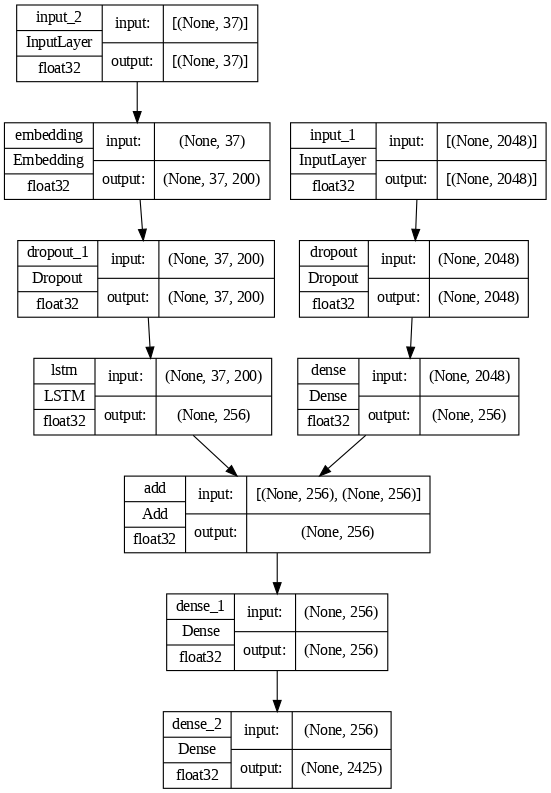

In [ ]:
keras.utils.plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [ ]:
model1.layers[2].set_weights([embedding_matrix])
model1.layers[2].trainable = False

In [ ]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

# Tạo early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Tạo callback để lưu trọng số của mô hình
checkpoint_path = "cp1.h5"
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, save_weights_only=True, verbose=1)


In [ ]:
model1.optimizer.lr = 0.001
epochs = 100
batch_size = 16
steps = len(images_train_encoded)

In [ ]:
batch_size = 16
train_generator = data_generator(captions=captions_train, images=images_train_encoded, w2i=w2i, max_length=max_length, batch_size=batch_size)
val_generator = data_generator(captions=captions_val, images=images_val_encoded, w2i=w2i, max_length=max_length, batch_size=batch_size)

In [ ]:
hist1 = model1.fit(train_generator, epochs=epochs, steps_per_epoch=len(images_train_encoded)//batch_size,
          validation_data=val_generator, validation_steps=len(images_val_encoded)//batch_size,
          verbose=1, callbacks=[cp_callback, early_stopping])

Epoch 1/100
505/505 [==============================] - ETA: 0s - loss: 4.0847 - accuracy: 0.2757
Epoch 1: saving model to cp1.h5
505/505 [==============================] - 93s 169ms/step - loss: 4.0847 - accuracy: 0.2757 - val_loss: 3.4823 - val_accuracy: 0.3290
Epoch 2/100
505/505 [==============================] - ETA: 0s - loss: 3.3316 - accuracy: 0.3385
Epoch 2: saving model to cp1.h5
505/505 [==============================] - 74s 147ms/step - loss: 3.3316 - accuracy: 0.3385 - val_loss: 3.2291 - val_accuracy: 0.3539
Epoch 3/100
505/505 [==============================] - ETA: 0s - loss: 3.1095 - accuracy: 0.3573
Epoch 3: saving model to cp1.h5
505/505 [==============================] - 74s 147ms/step - loss: 3.1095 - accuracy: 0.3573 - val_loss: 3.1130 - val_accuracy: 0.3660
Epoch 4/100
505/505 [==============================] - ETA: 0s - loss: 2.9741 - accuracy: 0.3688
Epoch 4: saving model to cp1.h5
505/505 [==============================] - 69s 137ms/step - loss: 2.9741 - accurac

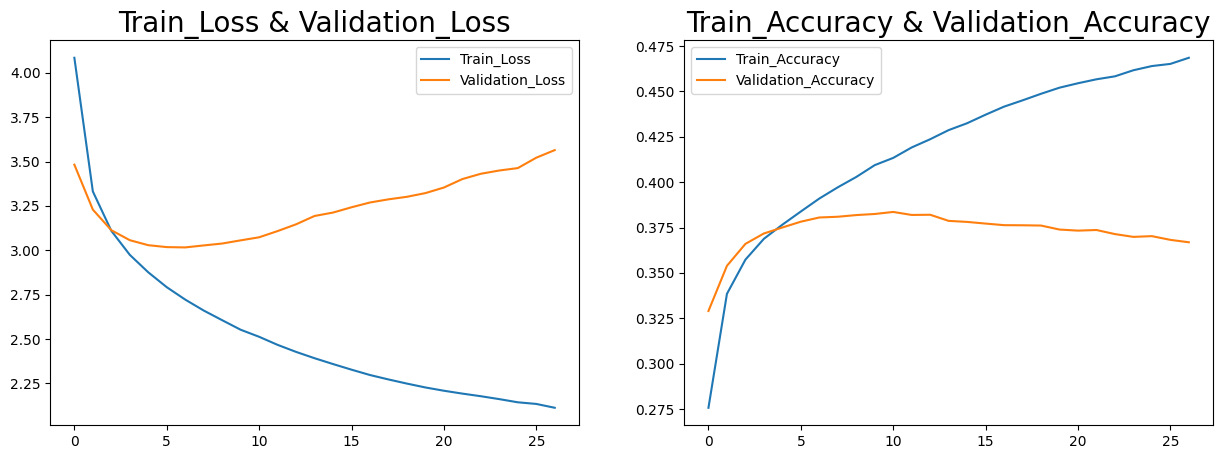

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist1.history['loss'],label='Train_Loss')
plt.plot(hist1.history['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist1.history['accuracy'],label='Train_Accuracy')
plt.plot(hist1.history['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
model1.load_weights(checkpoint_path)

In [ ]:
def create_model_with_attention():
  input_image = Input(shape=(2048, ), name='Image_Feature_input')
  fe1 = Dropout(0.5, name='Dropout_image')(input_image)
  fe2 = Dense(256, activation='relu', name='Activation_Encoder')(fe1)
  input_text = Input(shape=(max_length,), name='Text_input')
  # se1 = Embedding(vocab_size, 500, mask_zero=True, name='Text_Feature')(input_text)
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, name='Text_Feature')(input_text)
  se2 = Dropout(0.5, name='Dropout_text')(se1)
  se3 = Bidirectional(LSTM(512, name='Bidirectional-LSTM', return_sequences=True))(se2)
  se4 = SeqSelfAttention(attention_activation='sigmoid', name='Self-Attention')(se3)
  se5 = Flatten()(se4)
  se6 = Dense(256, activation='relu')(se5)
  decoder1 = Concatenate(name='Concatenate')([fe2, se6])
  decoder2 = Dense(256, activation='relu', name='Activation_Decoder')(decoder1)
  output = Dense(vocab_size, activation='softmax',name='Output')(decoder2)
  model2 = Model(inputs=[input_image, input_text], outputs=output)
  return model2

model2 = create_model_with_attention()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


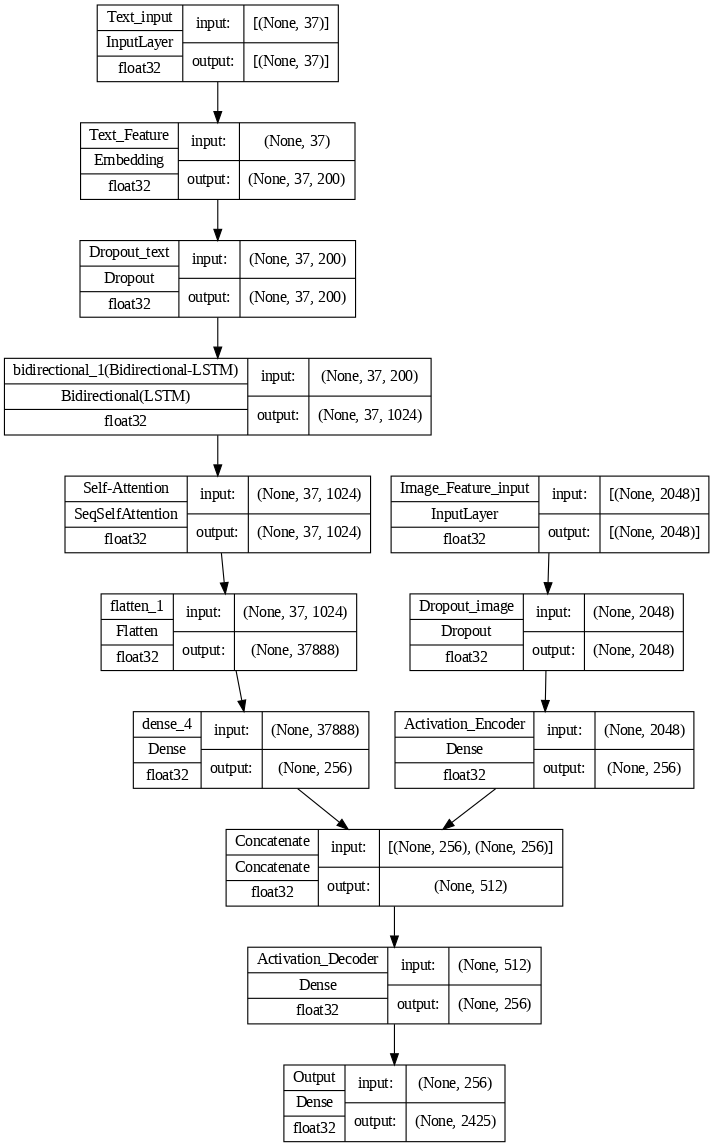

In [ ]:
keras.utils.plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Text_input (InputLayer)     [(None, 37)]                 0         []                            
                                                                                                  
 Text_Feature (Embedding)    (None, 37, 200)              485000    ['Text_input[0][0]']          
                                                                                                  
 Dropout_text (Dropout)      (None, 37, 200)              0         ['Text_Feature[0][0]']        
                                                                                                  
 bidirectional (Bidirection  (None, 37, 1024)             2920448   ['Dropout_text[0][0]']        
 al)                                                                                        

In [ ]:
model2.layers[1].set_weights([embedding_matrix])
model2.layers[1].trainable = False

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint_path2 = "cp_attention.h5"
cp_callback2 = ModelCheckpoint(filepath=checkpoint_path2, save_best_only=False, save_weights_only=True, verbose=1)

In [ ]:
model2.optimizer.lr = 0.001
epochs = 100
batch_size = 16
steps = len(images_train_encoded)

hist2 = model2.fit(train_generator, epochs=epochs, steps_per_epoch=len(images_train_encoded)//batch_size,
          validation_data=val_generator, validation_steps=len(images_val_encoded)//batch_size,
          verbose=1, callbacks=[cp_callback2, early_stopping])

Epoch 1/100
505/505 [==============================] - ETA: 0s - loss: 4.0324 - accuracy: 0.2786
Epoch 1: saving model to cp_attention.h5
505/505 [==============================] - 183s 342ms/step - loss: 4.0324 - accuracy: 0.2786 - val_loss: 3.4584 - val_accuracy: 0.3304
Epoch 2/100
505/505 [==============================] - ETA: 0s - loss: 3.3516 - accuracy: 0.3345
Epoch 2: saving model to cp_attention.h5
505/505 [==============================] - 164s 324ms/step - loss: 3.3516 - accuracy: 0.3345 - val_loss: 3.2368 - val_accuracy: 0.3523
Epoch 3/100
505/505 [==============================] - ETA: 0s - loss: 3.1446 - accuracy: 0.3511
Epoch 3: saving model to cp_attention.h5
505/505 [==============================] - 171s 339ms/step - loss: 3.1446 - accuracy: 0.3511 - val_loss: 3.1507 - val_accuracy: 0.3616
Epoch 4/100
505/505 [==============================] - ETA: 0s - loss: 3.0169 - accuracy: 0.3618
Epoch 4: saving model to cp_attention.h5
505/505 [==============================] - 

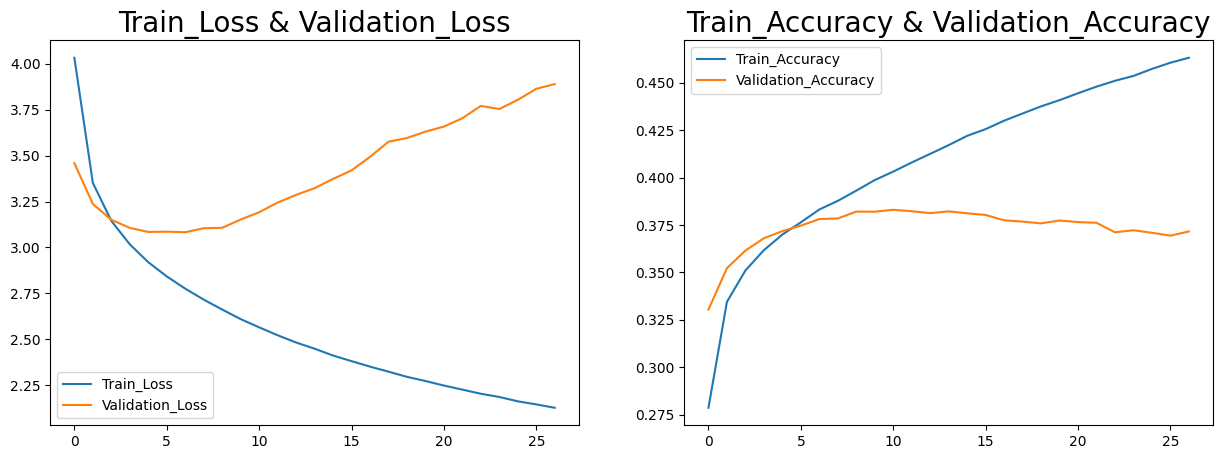

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist2.history['loss'],label='Train_Loss')
plt.plot(hist2.history['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist2.history['accuracy'],label='Train_Accuracy')
plt.plot(hist2.history['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
model2.load_weights(checkpoint_path2)

In [ ]:
def greedySearch(model, photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search(model, photo, beam_width=5):
    start = [w2i['startseq']]
    in_text = [[start, 0.0]]

    for _ in range(max_length):
        temp_list = []

        for seq in in_text:
            sequence = pad_sequences([seq[0]], maxlen=max_length)
            yhat = model.predict([photo, sequence], verbose=0)
            top_k = np.argsort(yhat[0])[-beam_width:]

            for word in top_k:
                next_seq, prob = seq[0][:], seq[1]
                next_seq.append(word)
                prob += -np.log(yhat[0][word])
                temp_list.append([next_seq, prob])

        in_text = temp_list
        in_text = sorted(in_text, key=lambda l: l[1])
        in_text = in_text[:beam_width]

    final_caption = in_text[0][0]
    final_caption = [i2w[word] for word in final_caption]

    # Remove start and end tokens
    final_caption = [word for word in final_caption if word not in ['startseq', 'endseq']]

    final_caption = ' '.join(final_caption)

    return final_caption


def beam_search_with_self_attention(model, photo, beam_width=3):
    start = [w2i['startseq']]
    in_text = [[start, 0.0]]

    for _ in range(max_length):
        temp_list = []

        for seq in in_text:
            sequence = pad_sequences([seq[0]], maxlen=max_length)
            yhat = model.predict([photo, sequence], verbose=0)
            yhat, attention_weights = model.predict([photo, sequence], verbose=0)

            top_k = np.argsort(yhat[0])[-beam_width:]

            for word in top_k:
                next_seq, prob = seq[0][:], seq[1]
                next_seq.append(word)
                prob += -np.log(yhat[0][word])
                temp_list.append([next_seq, prob])

        in_text = temp_list
        in_text = sorted(in_text, key=lambda l: l[1])
        in_text = in_text[:beam_width]

    final_caption = in_text[0][0]
    final_caption = [i2w[word] for word in final_caption]

    # Remove start and end tokens
    final_caption = [word for word in final_caption if word not in ['startseq', 'endseq']]

    final_caption = ' '.join(final_caption)

    return final_caption



Caption: startseq the two dogs are running toward the camera endseq
Caption: startseq two dogs running along dirt path endseq
Caption: startseq two dogs running down a path in the woods endseq
Caption: startseq two dogs run through a field endseq
Caption: startseq two long haired dogs racing down a forest path endseq


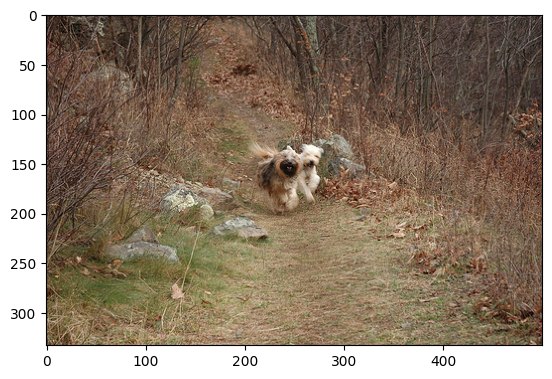

Greedy search: a dog is running through the grass  0.0
Beam search: a black and white dog is running through the grass a ball  0.0
Greedy search attention: a dog is digging in the grass  0.0


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

pic = list(images_train_encoded.keys())[1019]
image = images_train_encoded[pic].reshape((1,2048))
img = Image.open(image_path + pic)
captions_real = []
for caption in caption_df['caption'][caption_df['image'] == pic]:
    print(f"Caption: {caption}")
    captions_real.append(caption)
plt.imshow(img)
plt.show()
predict1 = greedySearch(model1, image)
predict2 = beam_search(model1, image)
predict3 = greedySearch(model2, image)

reference = [caption.split() for caption in captions_real]
candidate1 = predict1.split()
score1 = round(sentence_bleu(reference, candidate1), 3)
candidate2 = predict2.split()
score2 = round(sentence_bleu(reference, candidate2), 3)
candidate3 = predict3.split()
score3 = round(sentence_bleu(reference, candidate3), 3)

print(f"Greedy search: {predict1}  {score1}")
print(f"Beam search: {predict2}  {score2}")
print(f"Greedy search attention: {predict3}  {score3}")

In [ ]:
def plot_image_and_predict_caption():
    index = random.randint(0, len(images_val_encoded))
    pic = list(images_train_encoded.keys())[index]
    image = images_train_encoded[pic].reshape((1,2048))
    img = Image.open(image_path + pic)

    fcaptions_real = []
    for caption in caption_df['caption'][caption_df['image'] == pic]:
        print(f"Caption: {caption}")
        captions_real.append(caption)
    plt.imshow(img)
    plt.show()
    predict1 = greedySearch(model1, image)
    predict2 = beam_search(model1, image)
    predict3 = greedySearch(model2, image)
    reference = [caption.split() for caption in captions_real]
    candidate1 = predict1.split()
    score1 = round(sentence_bleu(reference, candidate1), 3)
    candidate2 = predict2.split()
    score2 = round(sentence_bleu(reference, candidate2), 3)
    candidate3 = predict3.split()
    score3 = round(sentence_bleu(reference, candidate3), 3)

    print(f"Greedy search: {predict1}  {score1}")
    print(f"Beam search: {predict2}  {score2}")
    print(f"Greedy search attention: {predict3}  {score3}")


Caption: startseq a boy is doing tricks with his bike on the ramp endseq
Caption: startseq a boy rides his bike on a halfpipe endseq
Caption: startseq a cyclist gets airborne on a ramp endseq
Caption: startseq a man on a bike jumping on a bike ramp endseq
Caption: startseq a teenage boy on a bicycle does tricks endseq


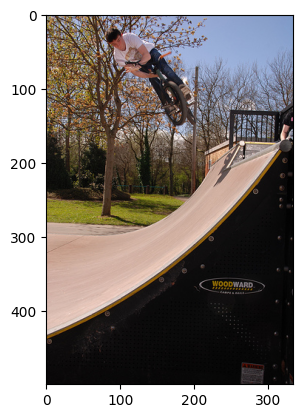

In [ ]:
plot_image_and_predict_caption()

In [ ]:
! pip install keras_multi_head